In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
model_dir = '/content/gdrive/My Drive/Winter 2020/DL/Project 2/models/'
!cp /content/gdrive/My\ Drive/Winter\ 2020/DL/Project\ 2/data/*.zip .
!unzip /content/sudoku.zip
!mkdir /content/test
!unzip /content/sudoku_test.zip -d /content/test
!mv /content/test/sudoku.csv /content/sudoku_test.csv

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Archive:  /content/sudoku.zip
  inflating: sudoku.csv              
Archive:  /content/sudoku_test.zip
  inflating: /content/test/sudoku.csv  


In [3]:
!git clone https://github.com/cloughurd/drl-sudoku.git
!mv drl-sudoku/data/* .
!mv drl-sudoku/models/* .

Cloning into 'drl-sudoku'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 154 (delta 90), reused 72 (delta 33), pack-reused 0
Receiving objects: 100% (154/154), 302.56 KiB | 3.60 MiB/s, done.
Resolving deltas: 100% (90/90), done.


In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from torch.utils.data.sampler import SubsetRandomSampler

assert torch.cuda.is_available()
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

In [20]:
from cnn import BasicNet, BigNet
from dataloader import *
from display import *

train_loader = get_loader(root='/content/', batch_size=512, train=True, mono=False, cap_train=1000000)
test_loader = get_loader(root='/content/', batch_size=1, train=False, mono=False)
const_x, const_y = next(iter(test_loader))
print(const_x, '\n', const_y)

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0

In [0]:
net = BasicNet(9)
net = net.cuda()
optimizer = optim.Adam(net.parameters(), lr=0.001)
objective = nn.CrossEntropyLoss()
losses = []

In [0]:
def train(num_epochs=20, print_val_freq=1000, save_freq=5000):
    step = 0
    for i in range(num_epochs):
        loop = tqdm(total=len(train_loader), position=0, leave=False)
        for x, y in train_loader:
            x = x.float()
            x = (x - 4.5) / 4.5
            x = x.cuda()
            y = y.cuda()
            optimizer.zero_grad()
            
            y_hat = net(x)
            
            loss = objective(y_hat.transpose(1,2), y.reshape((-1, 81)).long())
            loss.backward()
            optimizer.step()

            loop.set_description('epoch:{}, loss:{:.4f}'.format(i, loss.item()))
            loop.update(1)
            
            losses.append(loss.item())
            
            if step % print_val_freq == 0:
                const_y_hat = net(const_x.cuda().float()).detach().cpu()
                print('\n')
                print_tensor_puzzle(const_y_hat[0].reshape(9,9,9))
            if step % save_freq == 0:
                torch.save(net.state_dict(), model_dir + f'bignet-{i}.mod')
            step += 1

In [23]:
train(8)

epoch:0, loss:2.3844:   0%|          | 1/1954 [00:00<06:42,  4.86it/s]



|-------|-------|-------|
| 8 0 5 | 6 3 4 | 0 7 2 | 
| 1 4 0 | 6 6 8 | 2 5 6 | 
| 6 6 6 | 3 0 7 | 5 7 8 | 
|-------|-------|-------|
| 2 0 5 | 2 7 6 | 1 1 4 | 
| 7 4 4 | 2 3 5 | 8 4 2 | 
| 7 4 2 | 8 1 2 | 5 4 8 | 
|-------|-------|-------|
| 5 0 1 | 5 3 8 | 6 6 4 | 
| 0 3 6 | 3 4 1 | 5 2 8 | 
| 7 6 7 | 3 2 1 | 3 1 1 | 
|-------|-------|-------|


epoch:0, loss:0.6352:  51%|█████▏    | 1002/1954 [02:21<02:07,  7.48it/s]



|-------|-------|-------|
| 7 2 0 | 2 4 0 | 4 5 8 | 
| 2 5 4 | 2 1 8 | 5 5 0 | 
| 8 5 0 | 0 5 4 | 1 3 2 | 
|-------|-------|-------|
| 3 8 5 | 8 4 0 | 7 7 6 | 
| 0 8 7 | 5 4 5 | 2 4 4 | 
| 1 4 2 | 0 7 0 | 3 0 5 | 
|-------|-------|-------|
| 5 0 8 | 1 2 3 | 0 6 4 | 
| 3 0 2 | 4 3 7 | 1 8 5 | 
| 4 3 1 | 8 0 5 | 7 5 5 | 
|-------|-------|-------|


epoch:1, loss:0.4498:   2%|▏         | 48/1954 [00:07<04:49,  6.59it/s]



|-------|-------|-------|
| 8 5 0 | 2 4 4 | 4 4 5 | 
| 2 5 4 | 3 3 8 | 7 3 0 | 
| 3 6 0 | 0 5 4 | 4 3 2 | 
|-------|-------|-------|
| 7 2 5 | 0 4 4 | 4 0 6 | 
| 0 8 1 | 5 4 6 | 4 7 5 | 
| 6 4 6 | 8 7 2 | 5 0 5 | 
|-------|-------|-------|
| 5 7 8 | 7 2 3 | 0 6 4 | 
| 6 0 2 | 4 3 7 | 5 8 5 | 
| 4 3 7 | 8 0 5 | 2 1 7 | 
|-------|-------|-------|


epoch:1, loss:0.4049:  54%|█████▎    | 1048/1954 [02:29<02:08,  7.05it/s]



|-------|-------|-------|
| 7 0 3 | 2 1 0 | 8 4 8 | 
| 1 2 4 | 7 6 8 | 7 5 0 | 
| 8 6 8 | 0 5 0 | 4 4 2 | 
|-------|-------|-------|
| 2 5 5 | 0 8 0 | 8 7 6 | 
| 0 8 7 | 5 4 6 | 3 4 5 | 
| 6 4 6 | 5 7 2 | 8 0 8 | 
|-------|-------|-------|
| 5 7 8 | 1 2 3 | 0 2 4 | 
| 6 0 2 | 4 6 7 | 5 8 1 | 
| 4 3 1 | 8 0 5 | 2 6 3 | 
|-------|-------|-------|


epoch:2, loss:0.4034:   5%|▍         | 94/1954 [00:13<04:08,  7.49it/s]



|-------|-------|-------|
| 7 7 0 | 2 7 0 | 6 6 8 | 
| 2 2 4 | 7 7 8 | 1 5 0 | 
| 8 6 0 | 3 5 0 | 4 3 2 | 
|-------|-------|-------|
| 3 5 7 | 0 8 3 | 8 7 6 | 
| 0 8 7 | 5 4 6 | 4 5 5 | 
| 1 4 6 | 0 8 2 | 8 0 8 | 
|-------|-------|-------|
| 8 7 8 | 1 2 5 | 0 1 4 | 
| 6 0 2 | 4 3 7 | 5 8 1 | 
| 4 3 1 | 8 0 5 | 2 6 7 | 
|-------|-------|-------|


epoch:2, loss:0.3934:  56%|█████▌    | 1093/1954 [02:32<02:12,  6.49it/s]



|-------|-------|-------|
| 7 0 3 | 2 6 0 | 6 6 8 | 
| 2 2 4 | 1 5 8 | 6 6 0 | 
| 5 6 0 | 0 1 4 | 4 3 2 | 
|-------|-------|-------|
| 2 2 5 | 0 8 5 | 8 7 6 | 
| 0 8 5 | 5 5 6 | 3 1 5 | 
| 6 5 6 | 0 7 2 | 8 0 5 | 
|-------|-------|-------|
| 8 1 6 | 5 2 3 | 0 6 4 | 
| 6 0 2 | 4 1 7 | 5 8 1 | 
| 4 3 5 | 8 0 5 | 2 6 1 | 
|-------|-------|-------|


epoch:3, loss:0.3816:   7%|▋         | 140/1954 [00:19<04:05,  7.37it/s]



|-------|-------|-------|
| 8 0 3 | 2 6 0 | 6 5 8 | 
| 2 2 4 | 7 5 8 | 1 5 0 | 
| 8 6 8 | 0 4 4 | 8 3 2 | 
|-------|-------|-------|
| 1 4 5 | 0 8 4 | 8 2 6 | 
| 0 8 5 | 5 4 6 | 3 1 5 | 
| 6 4 6 | 0 8 2 | 8 0 8 | 
|-------|-------|-------|
| 8 5 8 | 5 2 3 | 0 6 4 | 
| 6 0 2 | 4 3 3 | 5 8 1 | 
| 4 3 6 | 8 0 5 | 2 6 7 | 
|-------|-------|-------|


epoch:3, loss:0.4003:  58%|█████▊    | 1140/1954 [02:37<02:04,  6.54it/s]



|-------|-------|-------|
| 5 0 3 | 2 4 5 | 7 4 5 | 
| 2 2 4 | 3 3 8 | 1 5 0 | 
| 5 6 0 | 0 4 4 | 8 3 2 | 
|-------|-------|-------|
| 2 2 1 | 0 8 3 | 8 7 6 | 
| 0 8 7 | 1 4 6 | 3 2 5 | 
| 6 4 6 | 0 7 2 | 8 5 8 | 
|-------|-------|-------|
| 8 7 8 | 6 5 5 | 0 1 4 | 
| 1 0 2 | 4 6 7 | 5 8 3 | 
| 4 3 5 | 8 0 1 | 2 1 7 | 
|-------|-------|-------|


epoch:4, loss:0.3806:  10%|▉         | 186/1954 [00:26<04:31,  6.50it/s]



|-------|-------|-------|
| 7 0 3 | 2 5 0 | 7 5 8 | 
| 2 2 4 | 7 6 8 | 7 5 0 | 
| 8 6 0 | 0 4 4 | 4 3 2 | 
|-------|-------|-------|
| 2 2 5 | 0 4 1 | 8 7 6 | 
| 0 8 7 | 5 4 6 | 3 4 5 | 
| 6 4 6 | 0 7 2 | 8 0 5 | 
|-------|-------|-------|
| 8 7 8 | 6 2 5 | 0 1 4 | 
| 4 0 2 | 4 5 7 | 5 8 1 | 
| 4 3 1 | 8 0 5 | 2 1 1 | 
|-------|-------|-------|


epoch:4, loss:0.3877:  61%|██████    | 1186/1954 [02:44<01:44,  7.38it/s]



|-------|-------|-------|
| 7 0 3 | 2 4 5 | 5 4 8 | 
| 7 2 4 | 1 1 8 | 7 1 0 | 
| 8 6 0 | 5 4 4 | 7 3 2 | 
|-------|-------|-------|
| 3 5 5 | 0 5 1 | 8 2 6 | 
| 0 8 5 | 5 4 6 | 3 4 5 | 
| 4 4 6 | 0 5 2 | 8 0 5 | 
|-------|-------|-------|
| 8 7 8 | 3 6 3 | 0 1 4 | 
| 6 0 2 | 4 1 7 | 1 8 3 | 
| 4 3 7 | 8 0 1 | 2 5 1 | 
|-------|-------|-------|


epoch:5, loss:0.3785:  12%|█▏        | 231/1954 [00:32<03:52,  7.40it/s]



|-------|-------|-------|
| 8 0 3 | 2 4 0 | 4 5 5 | 
| 2 2 4 | 1 7 8 | 6 5 0 | 
| 7 6 0 | 0 5 4 | 7 3 2 | 
|-------|-------|-------|
| 1 4 5 | 0 4 4 | 8 2 6 | 
| 0 8 7 | 5 4 6 | 3 4 1 | 
| 3 4 6 | 0 7 2 | 8 0 5 | 
|-------|-------|-------|
| 8 5 8 | 5 2 3 | 0 6 4 | 
| 5 0 2 | 4 6 7 | 5 8 3 | 
| 4 3 1 | 8 0 5 | 2 1 7 | 
|-------|-------|-------|


epoch:5, loss:0.3861:  63%|██████▎   | 1232/1954 [02:56<01:38,  7.33it/s]



|-------|-------|-------|
| 8 0 3 | 2 5 0 | 8 5 8 | 
| 2 2 4 | 7 6 8 | 6 5 0 | 
| 8 6 8 | 0 4 4 | 8 3 2 | 
|-------|-------|-------|
| 3 2 5 | 0 8 4 | 8 0 6 | 
| 0 8 5 | 7 5 6 | 3 4 5 | 
| 6 4 6 | 0 8 2 | 8 0 8 | 
|-------|-------|-------|
| 5 1 8 | 6 2 5 | 0 1 4 | 
| 6 0 2 | 4 1 7 | 5 8 3 | 
| 4 3 1 | 8 0 5 | 2 6 1 | 
|-------|-------|-------|


epoch:6, loss:0.3730:  14%|█▍        | 278/1954 [00:39<03:49,  7.31it/s]



|-------|-------|-------|
| 8 5 3 | 2 7 0 | 5 1 8 | 
| 1 2 4 | 3 1 8 | 7 5 0 | 
| 8 6 8 | 0 5 4 | 7 3 2 | 
|-------|-------|-------|
| 1 2 5 | 3 4 1 | 8 2 6 | 
| 0 8 1 | 5 4 6 | 3 4 1 | 
| 6 4 6 | 0 8 2 | 8 0 5 | 
|-------|-------|-------|
| 8 1 8 | 5 1 5 | 0 1 4 | 
| 1 0 2 | 4 3 7 | 1 8 3 | 
| 4 3 7 | 8 0 5 | 2 1 7 | 
|-------|-------|-------|


epoch:6, loss:0.3845:  65%|██████▌   | 1278/1954 [02:57<01:39,  6.80it/s]



|-------|-------|-------|
| 5 0 3 | 2 7 0 | 7 5 8 | 
| 2 2 4 | 7 5 8 | 7 5 0 | 
| 8 6 8 | 0 4 4 | 7 3 2 | 
|-------|-------|-------|
| 2 2 5 | 0 8 1 | 4 2 6 | 
| 0 8 1 | 5 4 6 | 3 2 1 | 
| 3 4 6 | 0 8 2 | 4 0 5 | 
|-------|-------|-------|
| 8 5 8 | 5 5 5 | 0 1 4 | 
| 5 0 2 | 4 1 7 | 8 8 3 | 
| 4 3 1 | 8 0 5 | 2 5 1 | 
|-------|-------|-------|


epoch:7, loss:0.3735:  17%|█▋        | 324/1954 [00:44<03:58,  6.84it/s]



|-------|-------|-------|
| 5 5 3 | 2 4 0 | 8 5 8 | 
| 5 5 4 | 7 3 8 | 7 5 0 | 
| 8 6 0 | 0 5 4 | 8 3 2 | 
|-------|-------|-------|
| 5 4 5 | 0 8 0 | 8 0 6 | 
| 0 8 5 | 5 4 6 | 3 4 1 | 
| 1 4 6 | 0 4 2 | 8 0 5 | 
|-------|-------|-------|
| 4 1 7 | 5 3 5 | 0 7 4 | 
| 7 0 2 | 4 1 7 | 5 8 7 | 
| 4 3 5 | 8 0 5 | 2 1 7 | 
|-------|-------|-------|


epoch:7, loss:0.3772:  68%|██████▊   | 1323/1954 [03:01<01:24,  7.50it/s]



|-------|-------|-------|
| 5 0 3 | 2 5 0 | 7 5 8 | 
| 8 2 4 | 6 8 8 | 7 5 0 | 
| 8 6 0 | 5 4 4 | 1 3 2 | 
|-------|-------|-------|
| 5 2 5 | 0 8 1 | 4 0 6 | 
| 0 8 1 | 7 4 6 | 3 2 1 | 
| 1 1 6 | 0 8 2 | 4 0 1 | 
|-------|-------|-------|
| 8 7 8 | 5 5 3 | 0 1 4 | 
| 1 0 2 | 4 3 7 | 5 8 1 | 
| 4 3 5 | 8 0 5 | 2 1 1 | 
|-------|-------|-------|


epoch:7, loss:0.4626: 100%|█████████▉| 1953/1954 [04:30<00:00,  7.83it/s]

In [0]:
753 260 148
214 738 650
860 154 732

325 081 476
087 546 321
146 372 805

578 623 014
602 417 583
431 805 267

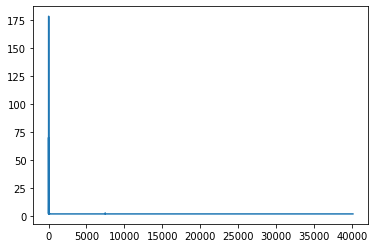

In [0]:
plt.plot(losses)
plt.show()

In [0]:
import json
json.dump(losses, open(model_dir + 'losses.json', 'w'), indent=4)

In [10]:
model_parameters = filter(lambda p: p.requires_grad, net.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

8257321